In [1]:
import random
import re
from datetime import date
from pathlib import Path
from typing import Union

import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import os
from os.path import join
import sys
sys.path.append('/media/medical/gasperp/projects')
from monai_3D_U_net.src import project_config
sys.path.append(project_config.projects_dir_path)
from utilities import utilities, visualization_functions
from monai_3D_U_net.src.nnUnet import nnunet_config
from monai_3D_U_net.src.nnUnet.plotting_jupyters import plot_functions, special_cases

/media/medical/gasperp/projects/nnUnet_clone/nnUNet/nnunet/results


In [4]:
def read_csv(dataset_name):
    df = pd.read_csv(
    os.path.join(
        f"/media/medical/projects/head_and_neck/nnUnet/{dataset}/results/", 
        f"results.csv",
    )
    )
    df.loc[df['parameters'].isna(), 'parameters'] = '/'
    return df
def drop_recurring_columns(df):
    df = df.copy()
    
    names_to_be_dropped = {}
    names_to_stay = {}
    for col_name in df.columns.names:
        col_vals = df.columns.get_level_values(col_name).unique().values.tolist()
        if len(col_vals) == 1:
            names_to_be_dropped[col_name] = col_vals[0]
        else:
            names_to_stay[col_name] = col_vals
    df.columns = df.columns.droplevel(list(names_to_be_dropped.keys()))
    return df, names_to_be_dropped, names_to_stay

def plot_boxplots(df: pd.DataFrame, selection: Union[dict, list], xlabel_col_name='organ_name'):
    if isinstance(selection, list):
        assert all([isinstance(i, dict) for i in selection]), "'selection' must either be dict or list of dicts"
        num_plots = len(selection)
    else:
        num_plots = 1
        selection = [selection]
        
    if num_plots == 1:
        ncols=1
        nrows=1
    else:
        ncols=2
        nrows = np.ceil(num_plots/ncols).astype(int)
        
    df, dropped_cols, _ = drop_recurring_columns(df)
    suptitle = ', '.join([f'{k}: {v}' for k, v in dropped_cols.items()])
    # if suptitle is very long: cut it in 100 characters pieces (each in new line)
    split_length = 100
    suptitle = '-\n'.join([suptitle[i:i+split_length] for i in range(0, len(suptitle), split_length)])
    
    print(nrows, ncols)
    
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 6*nrows+2), sharex=False, squeeze=False)
    fig.subplots_adjust(top=0.95)
    xlabels = df.columns.get_level_values(xlabel_col_name).unique().values.tolist()
    for _dict, ax in zip(selection, axes.flatten(order='F')):
        
        _df = df.xs(list(_dict.values()), level=list(_dict.keys()), axis=1)
        _df, _dropped, _ = drop_recurring_columns(_df)
        _df.boxplot(ax=ax, **dict(patch_artist=True))
        
        settings_dict = {**_dict, **_dropped}
        title = r', '.join([fr'{k}: $\bf{{{replace_underscore(v)}}}$' for k, v in settings_dict.items()])
        
        if ax.is_last_row():
            #ax.set_xticks(xlabels) 
            ax.set_xticklabels(xlabels)
            #ax.set_xticks(ax.get_xticks(), xlabels)    
            ax.tick_params(axis='x', labelrotation = 90)
        else:
            ax.set_xticklabels(['']*len(ax.get_xticks()))
        ax.set_title(title)
        # if metric is dice
        if 'dice' in str(_dict.get('metric')):
            ax.set_yticks(np.arange(0, 1.1, 0.1)) #, fontsize=12)
            
    fig.suptitle(suptitle, y=0.98)
    
def compute_mean_std_table(df_pivot):
    df_pivot_cleaned, _, _ = drop_recurring_columns(df_pivot)
    df_t = df_pivot_cleaned.transpose()
    # df_t
    # df_t.xs('Arytenoids', level='organ_name')
    df_t['mean +/-, std'] = df_t.mean(axis=1).round(2).astype(str) + ' +/- ' + df_t.std(axis=1).round(2).astype(str)
    df_t = df_t.drop(df_t.columns[:-2], axis=1).reset_index()
    df_t = df_t.pivot(index='organ_name', columns=['metric', 'phase'], values='mean +/-, std')
    return df_t.sort_index(axis=1)

pivot_nnunet_results_df = lambda in_df: pd.pivot_table(in_df, values='value', index=['fname'], columns=['model_task_name', 'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'fold', 'phase', 'metric', 'parameters', 'organ_name'])
replace_underscore = lambda s, r='\,': s.replace('_', r)

# ISBI plots

## LOAD 150
ISBI baseline model second attempt, all organs, CT and MRI T1 modalities, fixed image intensities anomalies in batch1, coregistered all images to common frame, all organs or nothing

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(33, 310)
[{'phase': 'test', 'metric': 'assd'}, {'phase': 'test', 'metric': 'average_surface_distance'}, {'phase': 'test', 'metric': 'hausdorff'}, {'phase': 'test', 'metric': 'surface_dice_at_tolerance'}, {'phase': 'test', 'metric': 'volumetric_dice'}, {'phase': 'train', 'metric': 'assd'}, {'phase': 'train', 'metric': 'average_surface_distance'}, {'phase': 'train', 'metric': 'hausdorff'}, {'phase': 'train', 'metric': 'surface_dice_at_tolerance'}, {'phase': 'train', 'metric': 'volumetric_dice'}] 10
5 2


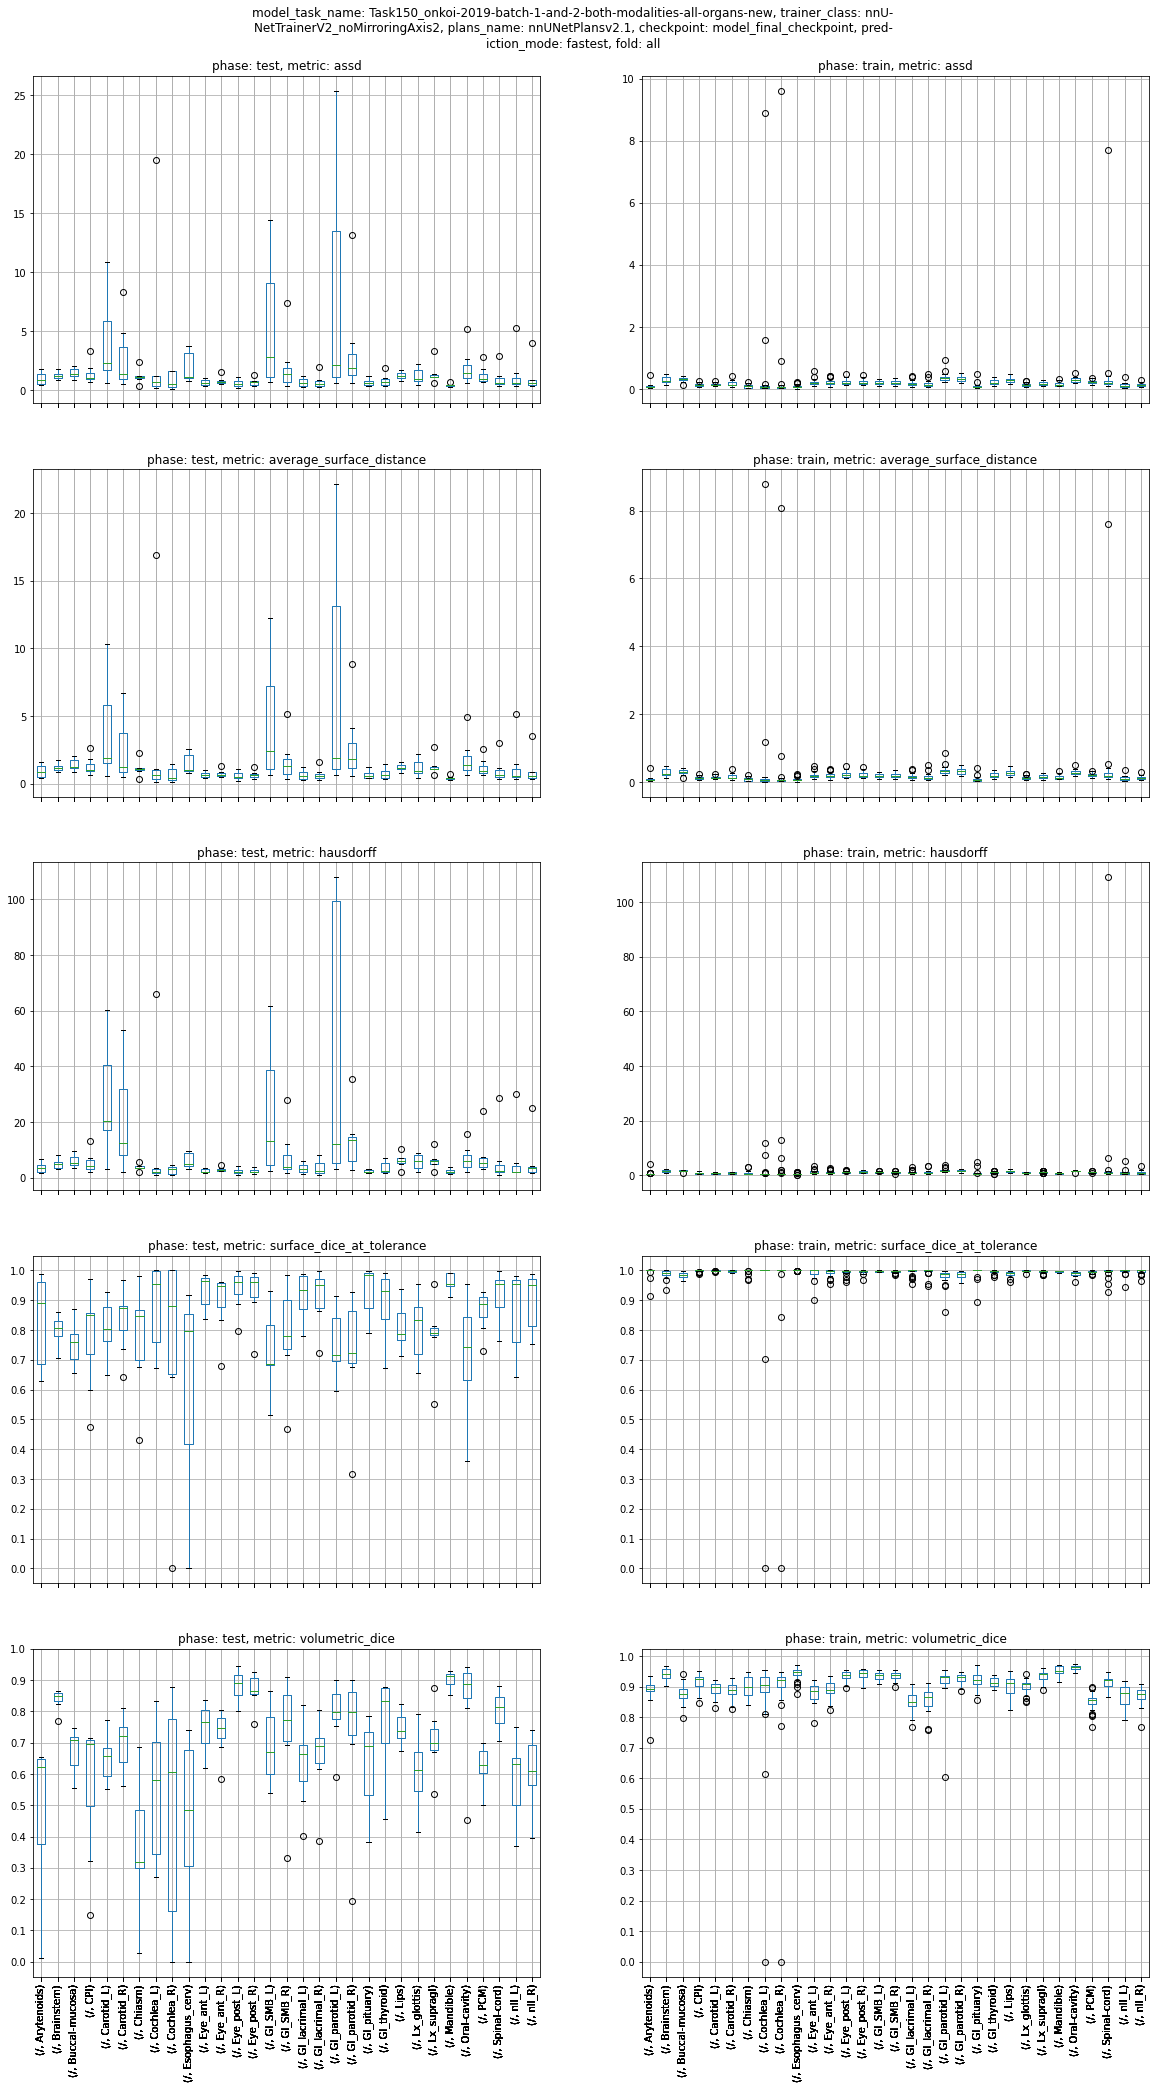

In [3]:
dataset = "Task150_onkoi-2019-batch-1-and-2-both-modalities-all-organs-new"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
df_pivot

df_pivot.columns.names
_, _, names_to_stay = drop_recurring_columns(df_pivot)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

## LOAD 154
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background and in ax to reduce size

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(56, 258)
{'model_task_name': 'Task154_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag-ax', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['no_parameters', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Brainstem', 'Buccal-mucosa', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_lacrimal_L', 'Gl_lacrimal_R', 'Gl_parotid_L', 'Gl_parotid_R', 'Gl_pituary', 'L

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: Matplotli

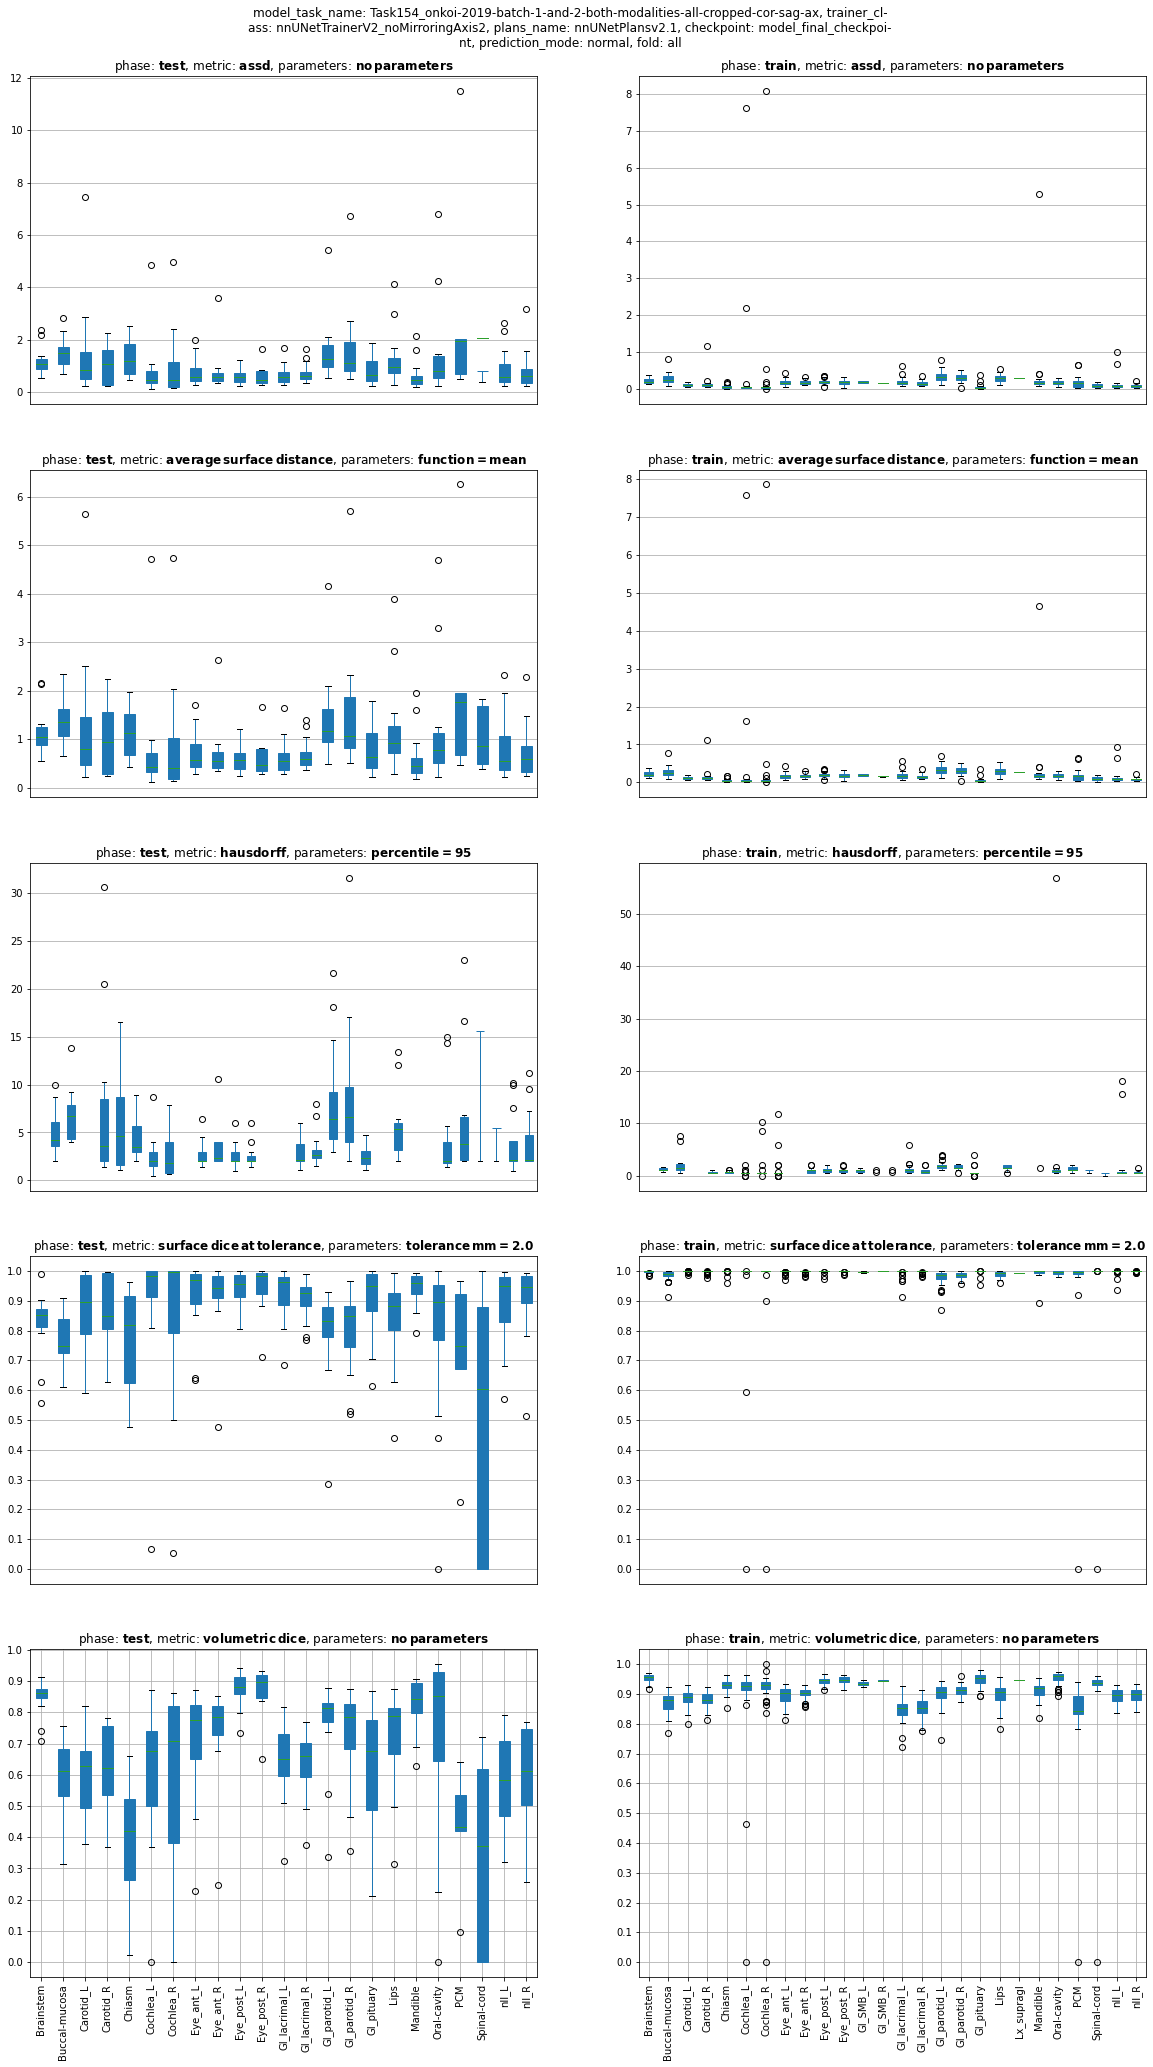

In [71]:
dataset = "Task154_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag-ax"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
_, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

## LOAD 155
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(56, 258)
{'model_task_name': 'Task155_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['/', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Brainstem', 'Buccal-mucosa', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_lacrimal_L', 'Gl_lacrimal_R', 'Gl_parotid_L', 'Gl_parotid_R', 'Gl_pituary', 'Lips', 'Mandible

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1183: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1128: 

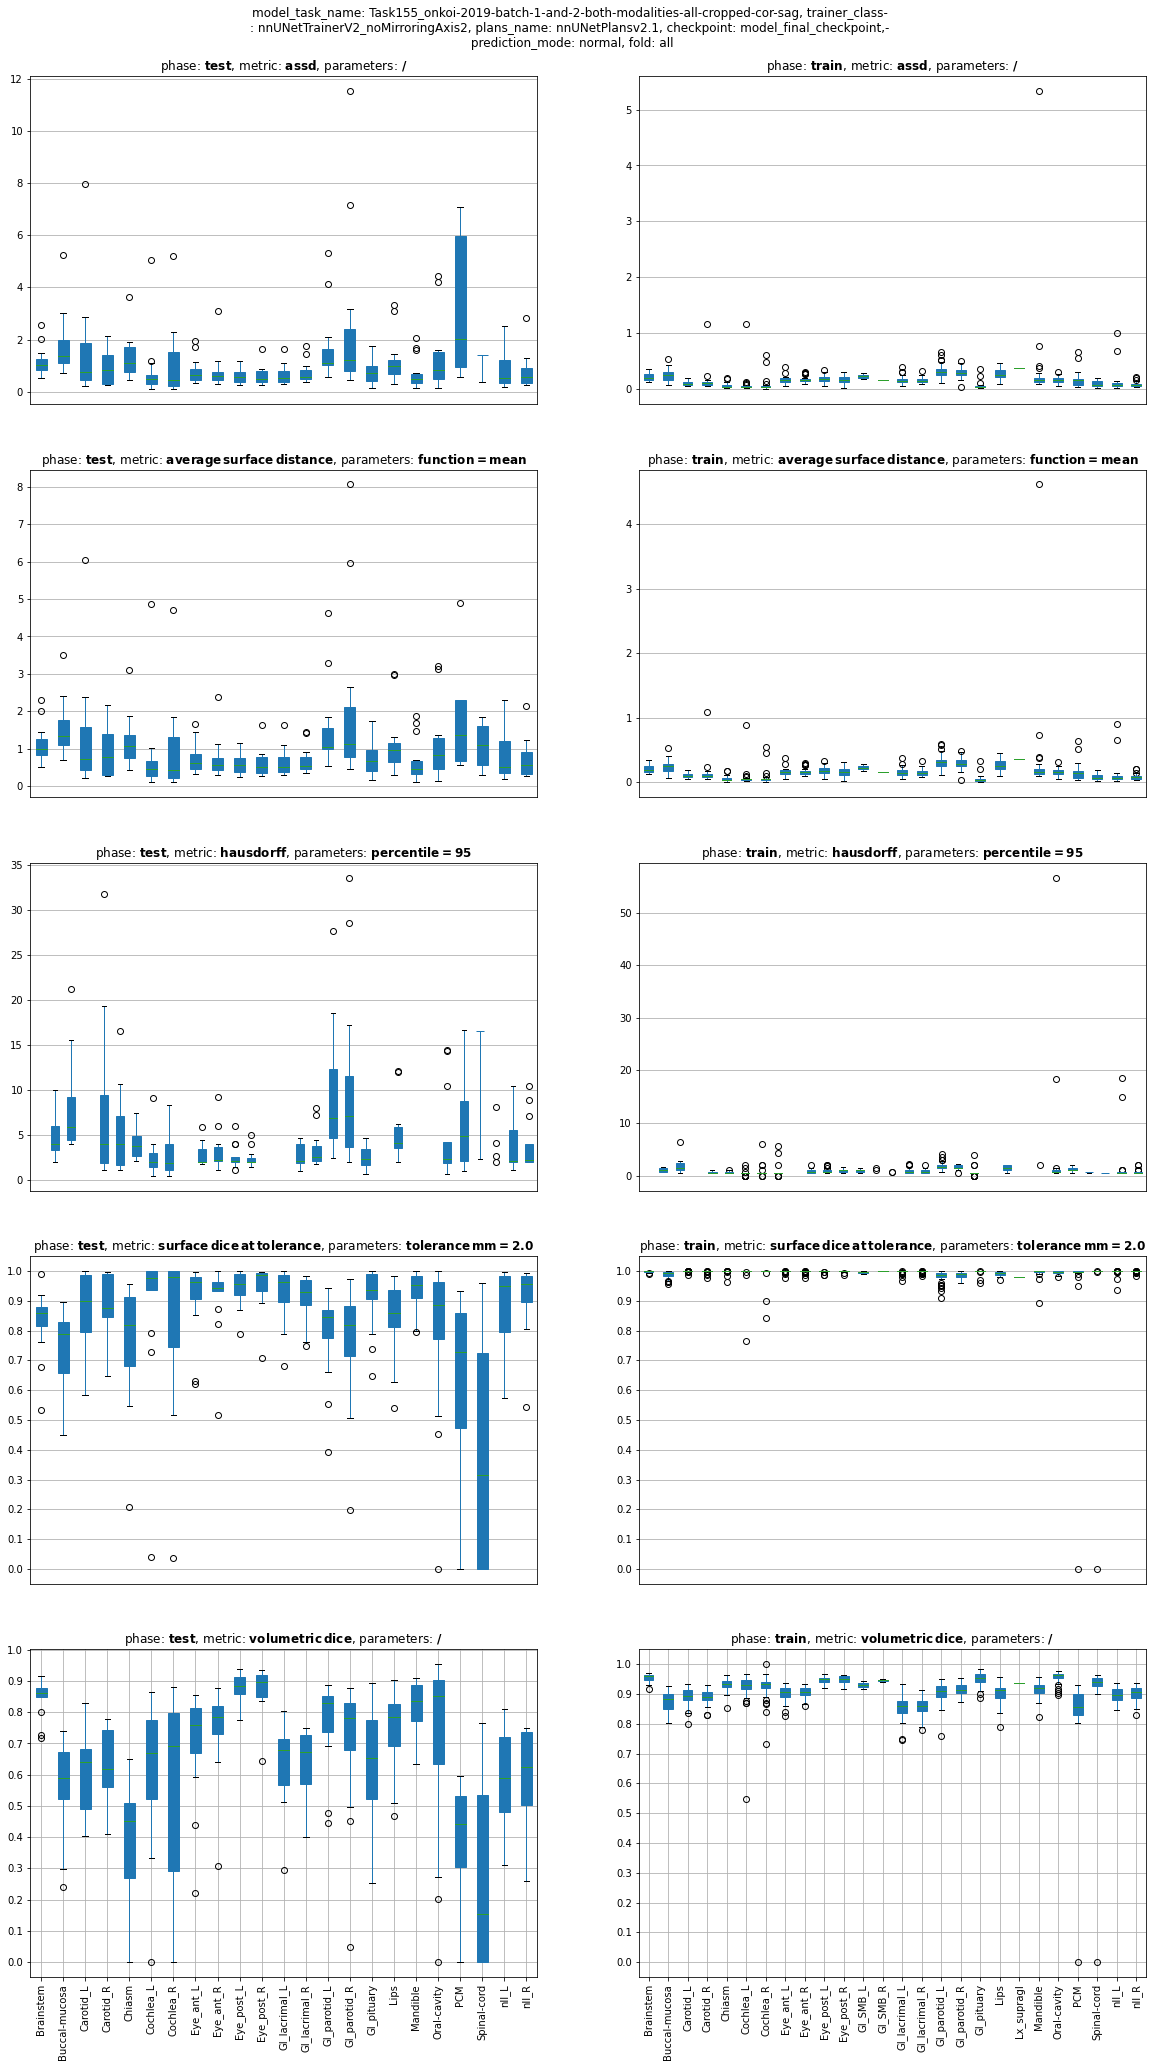

In [110]:
dataset = "Task155_onkoi-2019-batch-1-and-2-both-modalities-all-cropped-cor-sag"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
df_pivot_cleaned, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)

In [116]:
compute_mean_std_table(df_pivot)

metric,assd,average_surface_distance,hausdorff,surface_dice_at_tolerance,volumetric_dice,assd,average_surface_distance,hausdorff,surface_dice_at_tolerance,volumetric_dice
phase,test,test,test,test,test,train,train,train,train,train
organ_name,,,,,,,,,,
Arytenoids,NaN,NaN,inf +/- nan,NaN,NaN,NaN,NaN,inf +/- nan,NaN,NaN
Brainstem,1.19 +/- 0.54,1.15 +/- 0.49,5.01 +/- 2.39,0.83 +/- 0.11,0.85 +/- 0.06,0.21 +/- 0.07,0.21 +/- 0.06,inf +/- nan,1.0 +/- 0.0,0.95 +/- 0.01
Buccal-mucosa,1.83 +/- 1.22,1.58 +/- 0.77,inf +/- nan,0.73 +/- 0.13,0.57 +/- 0.16,0.25 +/- 0.1,0.24 +/- 0.1,inf +/- nan,0.99 +/- 0.01,0.88 +/- 0.03
CPI,NaN,NaN,inf +/- nan,NaN,NaN,NaN,NaN,inf +/- nan,NaN,NaN
Carotid_L,1.53 +/- 2.02,1.3 +/- 1.52,7.34 +/- 8.76,0.87 +/- 0.14,0.61 +/- 0.14,0.1 +/- 0.03,0.1 +/- 0.03,inf +/- nan,1.0 +/- 0.0,0.89 +/- 0.03
Carotid_R,0.92 +/- 0.66,0.87 +/- 0.63,5.37 +/- 4.58,0.89 +/- 0.11,0.63 +/- 0.12,0.13 +/- 0.17,0.13 +/- 0.16,inf +/- nan,1.0 +/- 0.0,0.89 +/- 0.02
Chiasm,1.29 +/- 0.83,1.18 +/- 0.68,4.09 +/- 1.68,0.77 +/- 0.2,0.39 +/- 0.19,0.05 +/- 0.04,0.05 +/- 0.04,inf +/- nan,1.0 +/- 0.01,0.93 +/- 0.02
Cochlea_L,0.84 +/- 1.25,0.8 +/- 1.2,2.55 +/- 2.12,0.88 +/- 0.26,0.6 +/- 0.24,0.07 +/- 0.18,0.07 +/- 0.13,inf +/- nan,0.99 +/- 0.04,0.92 +/- 0.06


## LOAD 156 
ISBI baseline model, all organs, CT and MRI T1 modalities, coregistered all images to common frame, cropped in cor and sag to eliminate background and in ax to reduce size

Index(['Unnamed: 0', 'organ_name', 'organ_label', 'metric', 'value',
       'parameters', 'model_task_number', 'model_task_name', 'fold',
       'trainer_class', 'plans_name', 'checkpoint', 'prediction_mode', 'phase',
       'fname'],
      dtype='object')
(56, 310)
{'model_task_name': 'Task156_onkoi-2019-isbi', 'trainer_class': 'nnUNetTrainerV2_noMirroringAxis2', 'plans_name': 'nnUNetPlansv2.1', 'checkpoint': 'model_final_checkpoint', 'prediction_mode': 'normal', 'fold': 'all'}
{'phase': ['test', 'train'], 'metric': ['assd', 'average_surface_distance', 'hausdorff', 'surface_dice_at_tolerance', 'volumetric_dice'], 'parameters': ['no_parameters', 'function=mean', 'percentile=95', 'tolerance_mm=2.0'], 'organ_name': ['Arytenoids', 'Brainstem', 'Buccal-mucosa', 'CPI', 'Carotid_L', 'Carotid_R', 'Chiasm', 'Cochlea_L', 'Cochlea_R', 'Esophagus_cerv', 'Eye_ant_L', 'Eye_ant_R', 'Eye_post_L', 'Eye_post_R', 'Gl_SMB_L', 'Gl_SMB_R', 'Gl_lacrimal_L', 'Gl_lacrimal_R', 'Gl_parotid_L', 'Gl_parotid_R', '

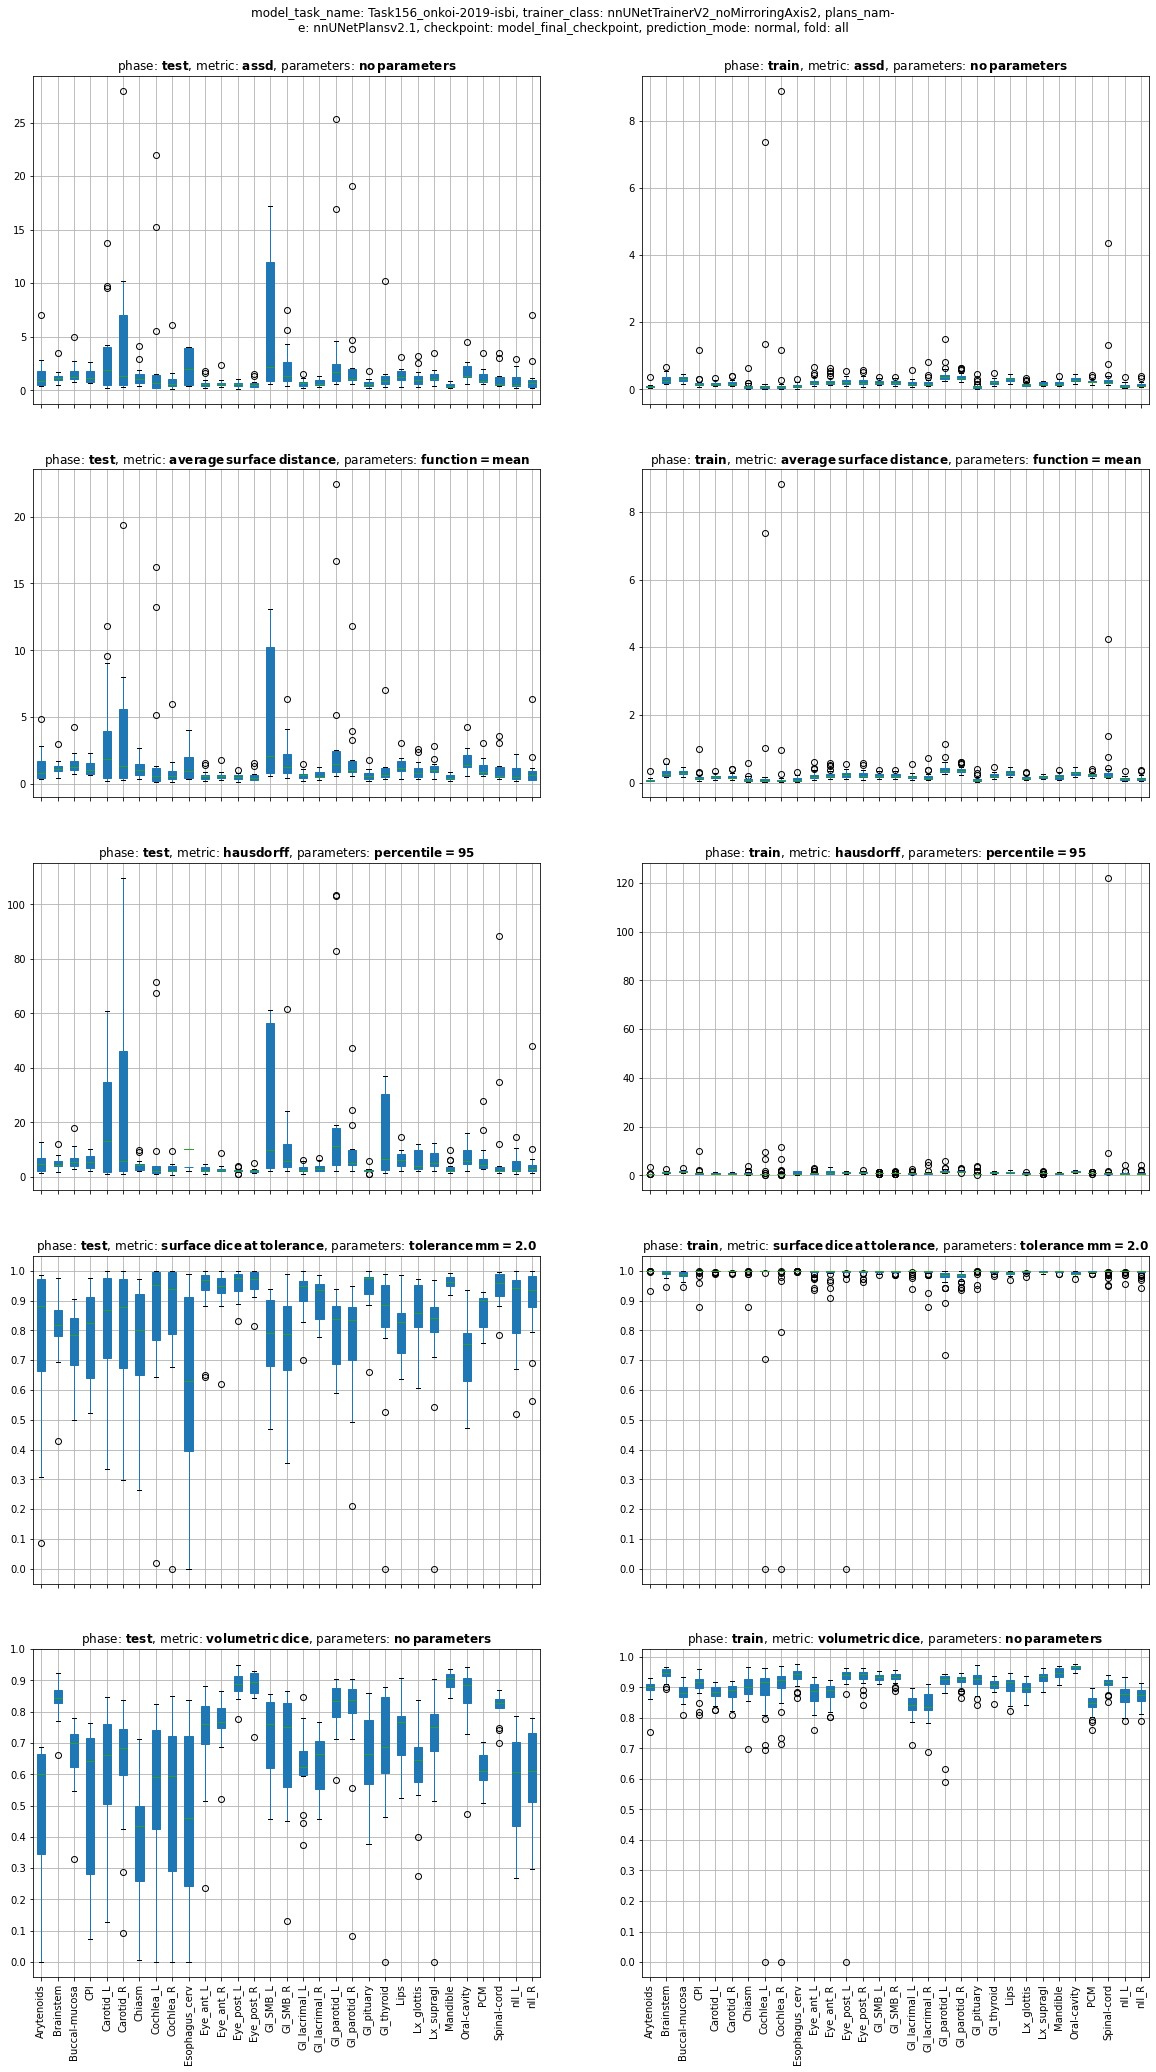

In [5]:
dataset = "Task156_onkoi-2019-isbi"
# stat_test = 'Mann-Whitney'
df = read_csv(dataset)
print(df.columns)
# df
df_pivot = pivot_nnunet_results_df(df)
print(df_pivot.shape)
# df_pivot

df_pivot.columns.names
df_pivot_cleaned, dropped_names, names_to_stay = drop_recurring_columns(df_pivot)
print(dropped_names)
print(names_to_stay)

plot_parameters = ('phase', 'metric')
_tmp = {k: vals for k, vals in names_to_stay.items() if k in plot_parameters}
combinations = [dict(zip(list(_tmp.keys()), combination)) for combination in itertools.product(*list(_tmp.values()))]
combinations
# print(combinations, len(combinations))
plot_boxplots(df_pivot, combinations)
plt.savefig('isbi_results.pdf')

In [6]:
df = compute_mean_std_table(df_pivot)
df.to_excel('isbi_excel.xlsx')
df

metric                   assd                average_surface_distance  \
phase                    test          train                     test   
organ_name                                                              
Arytenoids      1.58 +/- 1.88  0.08 +/- 0.05            1.34 +/- 1.33   
Brainstem        1.3 +/- 0.69  0.29 +/- 0.12            1.25 +/- 0.58   
Buccal-mucosa   1.66 +/- 1.08  0.31 +/- 0.07            1.56 +/- 0.91   
CPI             1.35 +/- 0.65  0.18 +/- 0.18            1.21 +/- 0.53   
Carotid_L       3.62 +/- 4.29  0.17 +/- 0.05            3.41 +/- 3.89   
Carotid_R       5.02 +/- 7.44  0.18 +/- 0.07            3.97 +/- 5.23   
Chiasm          1.38 +/- 1.04    0.1 +/- 0.1             1.2 +/- 0.72   
Cochlea_L       3.51 +/- 6.68  0.28 +/- 1.15            2.88 +/- 5.21   
Cochlea_R        1.1 +/- 1.53  0.31 +/- 1.39             1.02 +/- 1.5   
Esophagus_cerv    inf +/- nan   0.1 +/- 0.07             1.47 +/- 1.3   
Eye_ant_L        0.7 +/- 0.47  0.22 +/- 0.11            0.67 +/- 0.41   
Eye_ant_R         0.7 +/- 0.5  0.23 +/- 0.12            0.65 +/- 0.37   
Eye_post_L      0.55 +/- 0.24    inf +/- nan            0.54 +/- 0.24   
Eye_post_R       0.6 +/- 0.39   0.23 +/- 0.1             0.61 +/- 0.4   
Gl_SMB_L         5.7 +/- 6.25  0.21 +/- 0.06            4.97 +/- 5.26   
Gl_SMB_R        2.28 +/- 2.13  0.21 +/- 0.07            1.92 +/- 1.65   
Gl_lacrimal_L   0.72 +/- 0.36  0.18 +/- 0.09            0.69 +/- 0.34   
Gl_lacrimal_R   0.73 +/- 0.33  0.19 +/- 0.13             0.69 +/- 0.3   
Gl_parotid_L    4.47 +/- 7.33  0.42 +/- 0.21            4.23 +/- 6.69   
Gl_parotid_R    2.86 +/- 4.81   0.38 +/- 0.1            2.21 +/- 2.94   
Gl_pituary      0.68 +/- 0.41  0.09 +/- 0.08            0.67 +/- 0.41   
Gl_thyroid        inf +/- nan  0.22 +/- 0.08            1.35 +/- 1.92   
Lips            1.39 +/- 0.69   0.3 +/- 0.07            1.36 +/- 0.68   
Lx_glottis      1.18 +/- 0.89  0.15 +/- 0.05            1.08 +/- 0.76   
Lx_supragl        inf +/- nan  0.17 +/- 0.04            1.24 +/- 0.62   
Mandible        0.51 +/- 0.21  0.18 +/- 0.07            0.51 +/- 0.21   
Oral-cavity     1.73 +/- 1.04  0.29 +/- 0.07            1.69 +/- 0.99   
PCM             1.24 +/- 0.76  0.24 +/- 0.05            1.18 +/- 0.67   
Spinal-cord      1.1 +/- 0.98  0.36 +/- 0.66              1.1 +/- 1.0   
nII_L           0.96 +/- 0.84  0.11 +/- 0.06             0.89 +/- 0.7   
nII_R           1.21 +/- 1.79  0.13 +/- 0.07             1.1 +/- 1.58   

metric                               hausdorff                  \
phase                   train             test           train   
organ_name                                                       
Arytenoids      0.08 +/- 0.05      inf +/- nan     inf +/- nan   
Brainstem       0.28 +/- 0.11    5.39 +/- 2.58     inf +/- nan   
Buccal-mucosa    0.3 +/- 0.07     6.5 +/- 3.95    1.61 +/- 0.4   
CPI             0.17 +/- 0.15      inf +/- nan     inf +/- nan   
Carotid_L       0.17 +/- 0.05  21.15 +/- 22.72   0.76 +/- 0.25   
Carotid_R       0.17 +/- 0.07  25.19 +/- 32.82   0.74 +/- 0.25   
Chiasm          0.09 +/- 0.09    4.44 +/- 2.43     inf +/- nan   
Cochlea_L       0.27 +/- 1.15  12.31 +/- 24.34     inf +/- nan   
Cochlea_R        0.3 +/- 1.37    2.91 +/- 2.28     inf +/- nan   
Esophagus_cerv   0.1 +/- 0.07      inf +/- nan     inf +/- nan   
Eye_ant_L        0.21 +/- 0.1     2.6 +/- 1.21     inf +/- nan   
Eye_ant_R       0.23 +/- 0.11    3.01 +/- 1.81     inf +/- nan   
Eye_post_L      0.23 +/- 0.09    2.25 +/- 0.84     inf +/- nan   
Eye_post_R       0.23 +/- 0.1    2.22 +/- 0.91     inf +/- nan   
Gl_SMB_L        0.21 +/- 0.06  27.28 +/- 26.97   1.05 +/- 0.22   
Gl_SMB_R        0.21 +/- 0.06  11.74 +/- 15.56   1.09 +/- 0.28   
Gl_lacrimal_L   0.18 +/- 0.08    2.93 +/- 1.56     inf +/- nan   
Gl_lacrimal_R   0.19 +/- 0.11    3.34 +/- 1.51     inf +/- nan   
Gl_parotid_L     0.4 +/- 0.16  27.46 +/- 37.98   1.83 +/- 0.81   
Gl_parotid_R    0.37 +/- 0.09  10.61 +/- 12.38   1.72 +/- 0.36   

In [20]:
tuple(combinations[0].keys())

('phase', 'metric')

## Dice

(64, 512, 512)


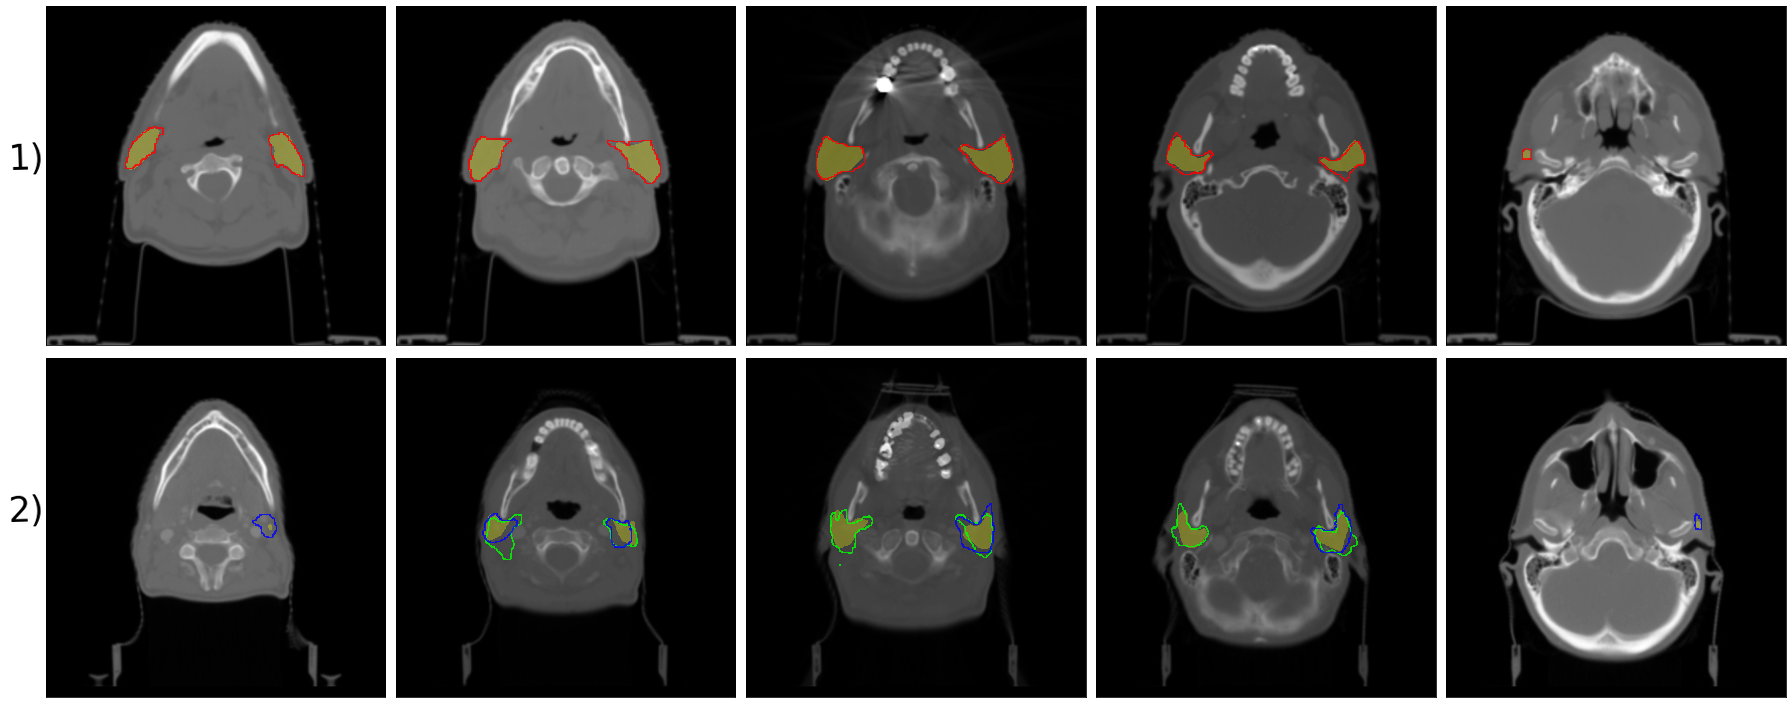

In [111]:
from matplotlib.colors import ListedColormap
import scipy.ndimage as ndimage
good_case = {'raw': '/media/medical/projects/head_and_neck/PDDCA/0522c0598/original/ct.nii.gz', 
             'name': 'PDDCA-HN1_047', 
             'dataset': 'Task124_PDDCA-HN1', 
            'img': '/media/medical/projects/head_and_neck/nnUnet/Task124_PDDCA-HN1/imagesTs/PDDCA-HN1_047_0000.nii.gz', 
            'gt': '/media/medical/projects/head_and_neck/nnUnet/Task124_PDDCA-HN1/labelsTs/PDDCA-HN1_047.nii.gz', 
            'pred': '/media/medical/projects/head_and_neck/nnUnet/Task124_PDDCA-HN1/results/foldall/local/test/PDDCA-HN1_047.nii.gz', }

bad_case = {'raw': '/media/medical/projects/head_and_neck/onkoi_2019/Original-dcm_conv_2/16/preprocessed/elastix_spline23/ct.nii.gz', 
            'name': 'onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053',
            'dataset': 'Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed',
           'img': '/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/imagesTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053_0000.nii.gz', 
            'pred': '/media/medical/projects/head_and_neck/nnUnet/Task129_PDDCA-HN1-ONKOI-double-reference-onkoi-10-train-20-test-noBadCasesInTrain/results/foldall/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/test/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053.nii.gz',
            'gt': ['/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/labelsTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_053.nii.gz', 
                  '/media/medical/projects/head_and_neck/nnUnet/Task113_onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed/labelsTs/onkoi-2019-double-reference-10-train-20-test-noBadCasesInTrain-spatialFixed_054.nii.gz']
           }

def load_sitk_and_to_np(pth):
    img_sitk = sitk.ReadImage(pth)
    spacing = img_sitk.GetSpacing() # cor, sag ,ax
    img_np = sitk.GetArrayFromImage(img_sitk)
    return img_np
def get_edge(slice_np):
    return ndimage.generic_gradient_magnitude(
        slice_np, ndimage.sobel
        ).astype(bool).astype(np.uint8)
def plot_case(axes, slices, image, gt, pred):
    mask_cmap_yellow = ListedColormap([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 0.0, 1.0]])
    mask_cmap_red = ListedColormap([[0.0, 0.0, 0.0, 0.0], [1.0, 0, 0.0, 1.0]])
    mask_cmap_blue = ListedColormap([[0.0, 0.0, 0.0, 0.0], [0, 0, 1.0, 1.0]])
    mask_cmap_green = ListedColormap([[0.0, 0.0, 0.0, 0.0], [0, 1.0, 0, 1.0]])
    gt_cmaps = [mask_cmap_green, mask_cmap_blue]
    
    if not isinstance(gt, (list, tuple)):
        gt = [gt]
        gt_cmaps = [mask_cmap_red]
        
    for enum, slc in enumerate(range(20,50,7)):
        ax = axes[enum]
        ax.imshow(image[slc], cmap='gray')
        ax.imshow(pred[slc], alpha=0.3, cmap=mask_cmap_yellow)
        for enum2, g in enumerate(gt):
            ax.imshow(get_edge(gt[enum2][slc]), alpha=0.8, cmap=gt_cmaps[enum2])
            
    [plt.setp(axi.get_xticklabels(), visible=False) for axi in axes.ravel()]
    [plt.setp(axi.get_yticklabels(), visible=False) for axi in axes.ravel()]
    [axi.tick_params(axis='both', which='both', length=0) for axi in axes.ravel()]
    
    
    
img_good = load_sitk_and_to_np(good_case['img'])
gt_good = load_sitk_and_to_np(good_case['gt'])
pred_good = load_sitk_and_to_np(good_case['pred'])
img_bad = load_sitk_and_to_np(bad_case['img'])
pred_bad = load_sitk_and_to_np(bad_case['pred'])
gt_bad = [load_sitk_and_to_np(i) for i in bad_case['gt']]

print(img_good.shape)
fig, axs = plt.subplots(2, 5, figsize=(25,10))
plot_case(axes=axs[0], slices=list(range(20,50,7)), image=img_good, gt=gt_good, pred=pred_good)
plot_case(axes=axs[1], slices=list(range(20,50,7)), image=img_bad, gt=gt_bad, pred=pred_bad)
[axs[i, 0].set_ylabel(f'{i+1})', rotation=np.pi/2, fontsize=35, labelpad=20) for i in range(axs.shape[0])]
plt.tight_layout()
# if save_plots: 
#     plt.savefig(f'figures/SPIE_best_worst.png', bbox_inches = 'tight', facecolor='white')

In [16]:
a = np.round(np.random.rand(3, 4)).astype(bool)*False
print(a)
a.astype(int).sum()

[[False False False False]
 [False False False False]
 [False False False False]]


0